Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from glob import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


In [3]:
# In my case dataset and notebook files are at below location
!ls ./gdrive/MyDrive/Colab-Notebooks/Upgrade/Test

'actinic keratosis'	 melanoma		      'seborrheic keratosis'
'basal cell carcinoma'	 nevus			      'squamous cell carcinoma'
 dermatofibroma		'pigmented benign keratosis'  'vascular lesion'


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Colab-Notebooks/Upgrade/Train/")
data_dir_test = pathlib.Path("/content/gdrive/MyDrive/Colab-Notebooks/Upgrade/Test/")

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, 
    batch_size=batch_size, 
    image_size=(img_height, img_width), 
    validation_split=0.2, 
    subset="training", 
    seed=123,
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, 
    batch_size=batch_size, 
    image_size=(img_height, img_width), 
    smart_resize=True, 
    validation_split=0.2, 
    subset="validation", 
    seed=123,
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

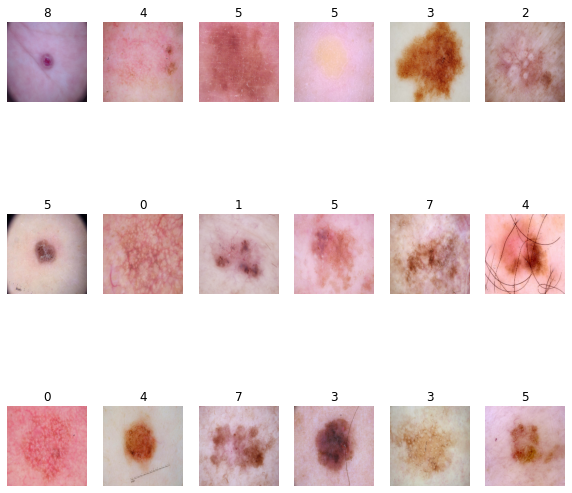

In [10]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(18):
        ax = plt.subplot(3, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
number_colour_layers = 3
image_size = (180, 180)
image_shape = image_size + (number_colour_layers,)

preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=image_shape)
]


def conv_2d_pooling_layers(filters, number_colour_layers):
    return [
        tf.keras.layers.Conv2D(
            filters,
            number_colour_layers,
            padding='same',
            activation='relu'
        ),
        tf.keras.layers.MaxPooling2D()
    ]

core_layers = \
    conv_2d_pooling_layers(16, number_colour_layers) + \
    conv_2d_pooling_layers(32, number_colour_layers) + \
    conv_2d_pooling_layers(64, number_colour_layers)


number_classes = 9
dense_layers = [
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(number_classes)
]


model = tf.keras.Sequential(
    preprocessing_layers +
    core_layers +
    dense_layers
)

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [13]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer='adam',
    loss=loss,
    metrics=['accuracy']
)

### Train the model

In [14]:
epochs = 20

history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs
)

Epoch 1/20
56/56 [==============================] - 419s 2s/step - loss: 2.1524 - accuracy: 0.2299 - val_loss: 1.9082 - val_accuracy: 0.2975
Epoch 2/20
56/56 [==============================] - 2s 42ms/step - loss: 1.7634 - accuracy: 0.3583 - val_loss: 1.6370 - val_accuracy: 0.4161
Epoch 3/20
56/56 [==============================] - 2s 40ms/step - loss: 1.5526 - accuracy: 0.4425 - val_loss: 1.5235 - val_accuracy: 0.4899
Epoch 4/20
56/56 [==============================] - 2s 40ms/step - loss: 1.4287 - accuracy: 0.4916 - val_loss: 1.4075 - val_accuracy: 0.5235
Epoch 5/20
56/56 [==============================] - 2s 40ms/step - loss: 1.3510 - accuracy: 0.5229 - val_loss: 1.4569 - val_accuracy: 0.4966
Epoch 6/20
56/56 [==============================] - 2s 40ms/step - loss: 1.2459 - accuracy: 0.5575 - val_loss: 1.3940 - val_accuracy: 0.5145
Epoch 7/20
56/56 [==============================] - 2s 41ms/step - loss: 1.1618 - accuracy: 0.5804 - val_loss: 1.4566 - val_accuracy: 0.4810
Epoch 8/20
56

### Visualizing training results

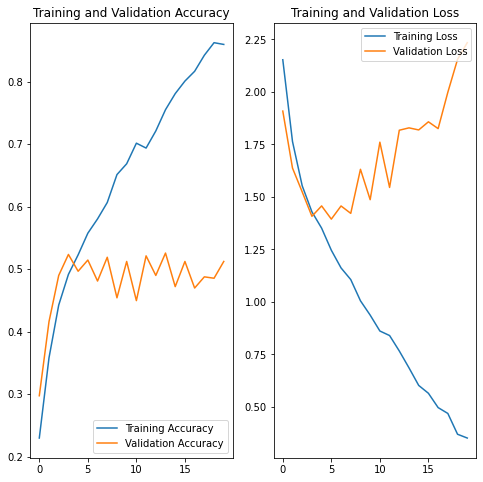

In [15]:
# compare the accuracy and val_accuracy

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

* There is a huge difference in accuracy and val_accuracy
* This is a sign of overfitting
* There might be class imbalance in our data
* We need to try the data augmentation so that we have diversed images

In [16]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.3),
        #layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.2))
    ]
)

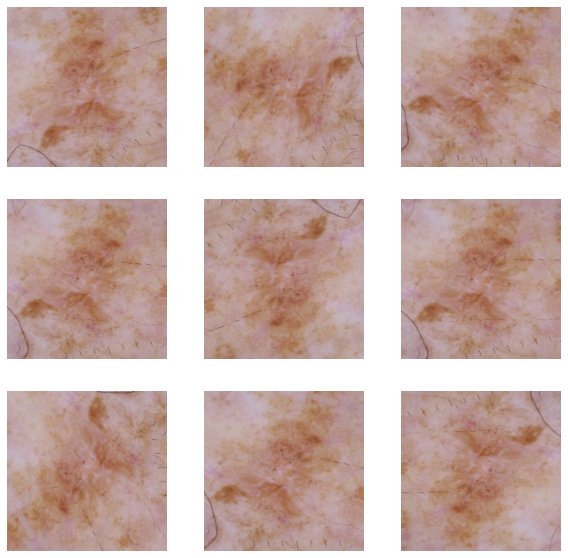

In [17]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [18]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=image_shape), 
    data_augmentation
]


def conv_2d_pooling_layers(filters, number_colour_layers):
    return [
        tf.keras.layers.Conv2D(
            filters,
            number_colour_layers,
            padding='same',
            activation='relu'
        ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Dropout(0.25)
    ]

core_layers = \
    conv_2d_pooling_layers(16, number_colour_layers) + \
    conv_2d_pooling_layers(32, number_colour_layers) + \
    conv_2d_pooling_layers(64, number_colour_layers)


number_classes = 9
dense_layers = [
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(number_classes)
]


model = tf.keras.Sequential(
    preprocessing_layers +
    core_layers +
    dense_layers
)

### Compiling the model

In [19]:
## Your code goes here
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer='adam',
    loss=loss,
    metrics=['accuracy']
)

### Training the model

In [20]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20

history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 20
)

Epoch 1/20
56/56 [==============================] - 4s 52ms/step - loss: 2.3168 - accuracy: 0.2037 - val_loss: 2.0491 - val_accuracy: 0.2886
Epoch 2/20
56/56 [==============================] - 3s 47ms/step - loss: 1.9293 - accuracy: 0.2868 - val_loss: 1.8899 - val_accuracy: 0.3333
Epoch 3/20
56/56 [==============================] - 3s 47ms/step - loss: 1.7539 - accuracy: 0.3733 - val_loss: 1.6701 - val_accuracy: 0.4407
Epoch 4/20
56/56 [==============================] - 3s 47ms/step - loss: 1.5996 - accuracy: 0.4336 - val_loss: 1.6516 - val_accuracy: 0.3960
Epoch 5/20
56/56 [==============================] - 3s 48ms/step - loss: 1.5012 - accuracy: 0.4810 - val_loss: 1.5093 - val_accuracy: 0.5078
Epoch 6/20
56/56 [==============================] - 3s 47ms/step - loss: 1.4594 - accuracy: 0.4805 - val_loss: 1.5202 - val_accuracy: 0.4586
Epoch 7/20
56/56 [==============================] - 3s 47ms/step - loss: 1.4262 - accuracy: 0.4978 - val_loss: 1.5443 - val_accuracy: 0.4944
Epoch 8/20
56

### Visualizing the results

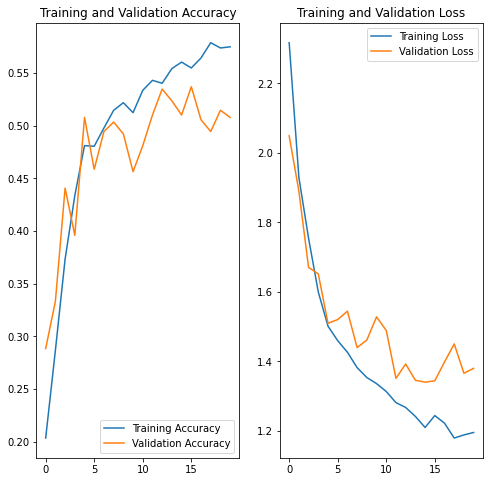

In [21]:
# compare the accuracy and val_accuracy

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

**Yes, There is an improvement. The difference between Accuracy and val_accuracy is much less. It seems like augmentation helps to overcome the overfitting.**

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [22]:
## Your code goes here.
classes = os.listdir("/content/gdrive/MyDrive/Colab-Notebooks/Upgrade/Train/")
print(classes)

os.chdir("/content/gdrive/MyDrive/Colab-Notebooks/Upgrade/Train/")
dist = [len(os.listdir(i)) for i in classes]
print(dist)

os.chdir("/content/gdrive/")

['melanoma', 'pigmented benign keratosis', 'basal cell carcinoma', 'nevus', 'seborrheic keratosis', 'squamous cell carcinoma', 'dermatofibroma', 'vascular lesion', 'actinic keratosis']
[438, 462, 376, 357, 77, 181, 95, 139, 114]


Text(0, 0.5, 'dist')

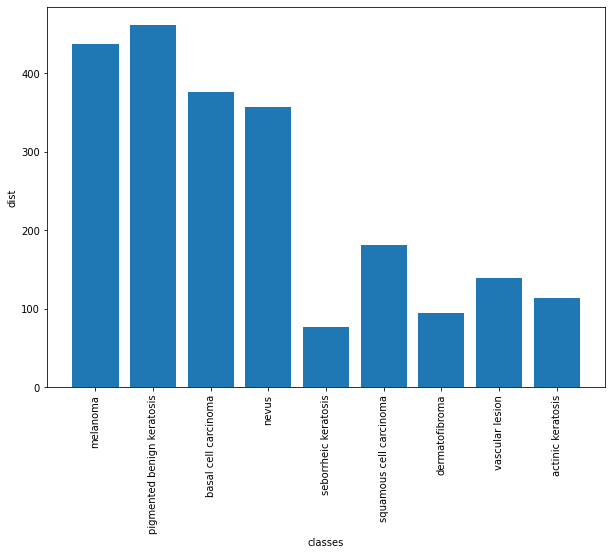

In [23]:
# Visualizing the number of images in respective classes
plt.figure(figsize=(10, 7))
plt.bar(classes, dist)
plt.xticks(rotation=90)
plt.xlabel('classes', )
plt.ylabel('dist')

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
**seborrheic keratosis class has the least number of samples**

#### - Which classes dominate the data in terms proportionate number of samples?
**'melanoma', 'pigmented benign keratosis' these classes dominate the data in terms of proportionate number of classes**


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [24]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [25]:
path_to_training_dataset="/content/gdrive/MyDrive/Colab-Notebooks/Upgrade/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab-Notebooks/Upgrade/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FAF7BD23590>: 100%|██████████| 500/500 [00:22<00:00, 21.98 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FAF7CD770D0>:   0%|          | 1/500 [00:00<01:06,  7.50 Samples/s]

Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab-Notebooks/Upgrade/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FAF781B0050>: 100%|██████████| 500/500 [00:22<00:00, 22.44 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab-Notebooks/Upgrade/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FAF781B0190>: 100%|██████████| 500/500 [00:22<00:00, 21.74 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab-Notebooks/Upgrade/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7FAF781F6BD0>: 100%|██████████| 500/500 [01:52<00:00,  4.43 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab-Notebooks/Upgrade/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FAF7827E650>: 100%|██████████| 500/500 [01:27<00:00,  5.74 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab-Notebooks/Upgrade/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FAF781B00D0>: 100%|██████████| 500/500 [00:22<00:00, 21.77 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab-Notebooks/Upgrade/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FAF7CDF4B90>: 100%|██████████| 500/500 [00:47<00:00, 10.42 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FAF78290290>:   0%|          | 1/500 [00:00<01:10,  7.12 Samples/s]

Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab-Notebooks/Upgrade/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FAF78199550>: 100%|██████████| 500/500 [00:22<00:00, 22.19 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab-Notebooks/Upgrade/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FAF7D7DC5D0>: 100%|██████████| 500/500 [00:23<00:00, 21.04 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [26]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [27]:
path_list_orig = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]

In [28]:
lesion_list_orig = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*', '*', '*.jpg'))]

### Lets see the distribution of augmented data after adding new images to the original training data.

In [29]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [30]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [31]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [32]:
original_df_new = dict(zip(path_list_orig, lesion_list_orig))

In [33]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
original_df = pd.DataFrame(list(original_df_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [34]:
# below weared output may be because of multiple execution.
new_df['Label'].value_counts()

nevus                         1000
melanoma                      1000
pigmented benign keratosis    1000
basal cell carcinoma          1000
seborrheic keratosis           739
vascular lesion                500
squamous cell carcinoma        500
actinic keratosis              500
dermatofibroma                 500
Name: Label, dtype: int64

In [35]:
list(new_df['Path'][2])

['/content/gdrive/MyDrive/Colab-Notebooks/Upgrade/Train/melanoma/ISIC_0000143.jpg',
 '/content/gdrive/MyDrive/Colab-Notebooks/Upgrade/Train/melanoma/output/melanoma_original_ISIC_0000554.jpg_17662ead-3e3e-4d5a-9243-f56614119eb5.jpg']

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [36]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [37]:
data_dir_train="/content/gdrive/MyDrive/Colab-Notebooks/Upgrade/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training", ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size = image_size,
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [38]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation", ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=image_size,
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [39]:
## your code goes here
# Added BatchNormalization to the model architecture 


preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=image_shape), 
    data_augmentation
]


def conv_2d_pooling_layers(filters, number_colour_layers):
    return [
        tf.keras.layers.Conv2D(
            filters,
            number_colour_layers,
            padding='same',
            activation='relu'
        ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Dropout(0.25)
    ]

core_layers = \
    conv_2d_pooling_layers(16, number_colour_layers) + \
    conv_2d_pooling_layers(32, number_colour_layers) + \
    conv_2d_pooling_layers(64, number_colour_layers)


number_classes = 9
dense_layers = [
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(number_classes)
]


model = tf.keras.Sequential(
    preprocessing_layers +
    core_layers +
    dense_layers
)

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [40]:
## your code goes here
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer='adam',
    loss=loss,
    metrics=['accuracy']
)

#### **Todo:**  Train your model

In [41]:
#epochs = 30
## Your code goes here, use 50 epochs.
#history = # your model fit code

epochs = 20

history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs
)

Epoch 1/20
169/169 [==============================] - 48s 271ms/step - loss: 2.5204 - accuracy: 0.3032 - val_loss: 16.3289 - val_accuracy: 0.1433
Epoch 2/20
169/169 [==============================] - 44s 255ms/step - loss: 1.6748 - accuracy: 0.3609 - val_loss: 9.0753 - val_accuracy: 0.1997
Epoch 3/20
169/169 [==============================] - 46s 264ms/step - loss: 1.5365 - accuracy: 0.4049 - val_loss: 4.5381 - val_accuracy: 0.2858
Epoch 4/20
169/169 [==============================] - 48s 277ms/step - loss: 1.4981 - accuracy: 0.4338 - val_loss: 2.5027 - val_accuracy: 0.3534
Epoch 5/20
169/169 [==============================] - 48s 275ms/step - loss: 1.4260 - accuracy: 0.4572 - val_loss: 2.4500 - val_accuracy: 0.3727
Epoch 6/20
169/169 [==============================] - 48s 276ms/step - loss: 1.3970 - accuracy: 0.4568 - val_loss: 2.1744 - val_accuracy: 0.3727
Epoch 7/20
169/169 [==============================] - 45s 261ms/step - loss: 1.3678 - accuracy: 0.4696 - val_loss: 1.6080 - val_a

#### **Todo:**  Visualize the model results

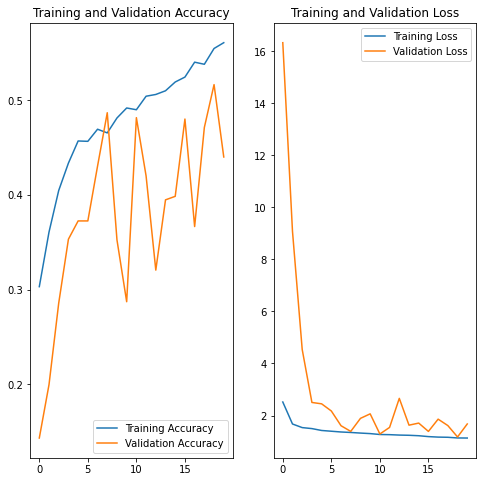

In [42]:
# compare the accuracy and val_accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [43]:
## your code goes here
## Added additional convolution set to our architecture


preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=image_shape), 
    data_augmentation
]


def conv_2d_pooling_layers(filters, number_colour_layers):
    return [
        tf.keras.layers.Conv2D(
            filters,
            number_colour_layers,
            padding='same',
            activation='relu'
        ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(
            filters,
            number_colour_layers,
            padding='same',
            activation='relu'
        ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Dropout(0.25)
    ]

core_layers = \
    conv_2d_pooling_layers(16, number_colour_layers) + \
    conv_2d_pooling_layers(32, number_colour_layers) + \
    conv_2d_pooling_layers(64, number_colour_layers)


number_classes = 9
dense_layers = [
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(number_classes)
]


model = tf.keras.Sequential(
    preprocessing_layers +
    core_layers +
    dense_layers
)

In [44]:
## your code goes here
# train model this time with 50 epochs
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer='adam',
    loss=loss,
    metrics=['accuracy']
)

epochs = 50

history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs
)

Epoch 1/50
169/169 [==============================] - 57s 318ms/step - loss: 2.8497 - accuracy: 0.2513 - val_loss: 6.2223 - val_accuracy: 0.1403
Epoch 2/50
169/169 [==============================] - 56s 325ms/step - loss: 1.8259 - accuracy: 0.3121 - val_loss: 8.9762 - val_accuracy: 0.1403
Epoch 3/50
169/169 [==============================] - 56s 323ms/step - loss: 1.7080 - accuracy: 0.3657 - val_loss: 18.8946 - val_accuracy: 0.1262
Epoch 4/50
169/169 [==============================] - 56s 325ms/step - loss: 1.6528 - accuracy: 0.3759 - val_loss: 1.9975 - val_accuracy: 0.3215
Epoch 5/50
169/169 [==============================] - 56s 324ms/step - loss: 1.5591 - accuracy: 0.4023 - val_loss: 2.9719 - val_accuracy: 0.2502
Epoch 6/50
169/169 [==============================] - 56s 325ms/step - loss: 1.4797 - accuracy: 0.4254 - val_loss: 1.4471 - val_accuracy: 0.4365
Epoch 7/50
169/169 [==============================] - 56s 324ms/step - loss: 1.4616 - accuracy: 0.4277 - val_loss: 2.6215 - val_a

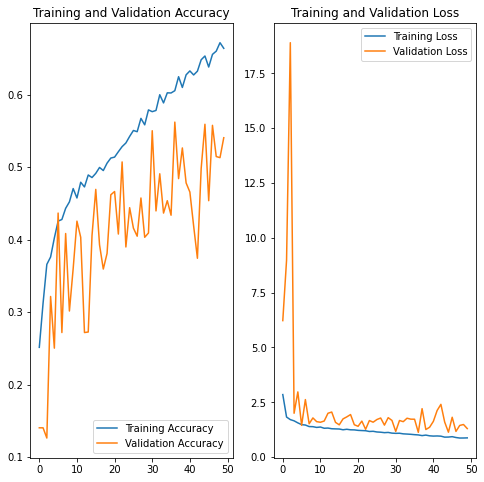

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

** Now we can the see the improvement in our model and there is not much difference in training and validation accuracy**

**It seems the augmentor helps to remove the overfitting which caused by class imbalance.**

**If we further tune our model we will achieve much more better accuracy**

**Due to GPU usage restriction and unavailability of GPU access on colab** 



